# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector. 
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

--------

## Step 0: Preparation

Here, we will prepare our dataset that we're going to use for feature extraction. The result will be two pickle files, one with all of our car images and another one for our notcar images. This first part will only need to be run once.

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


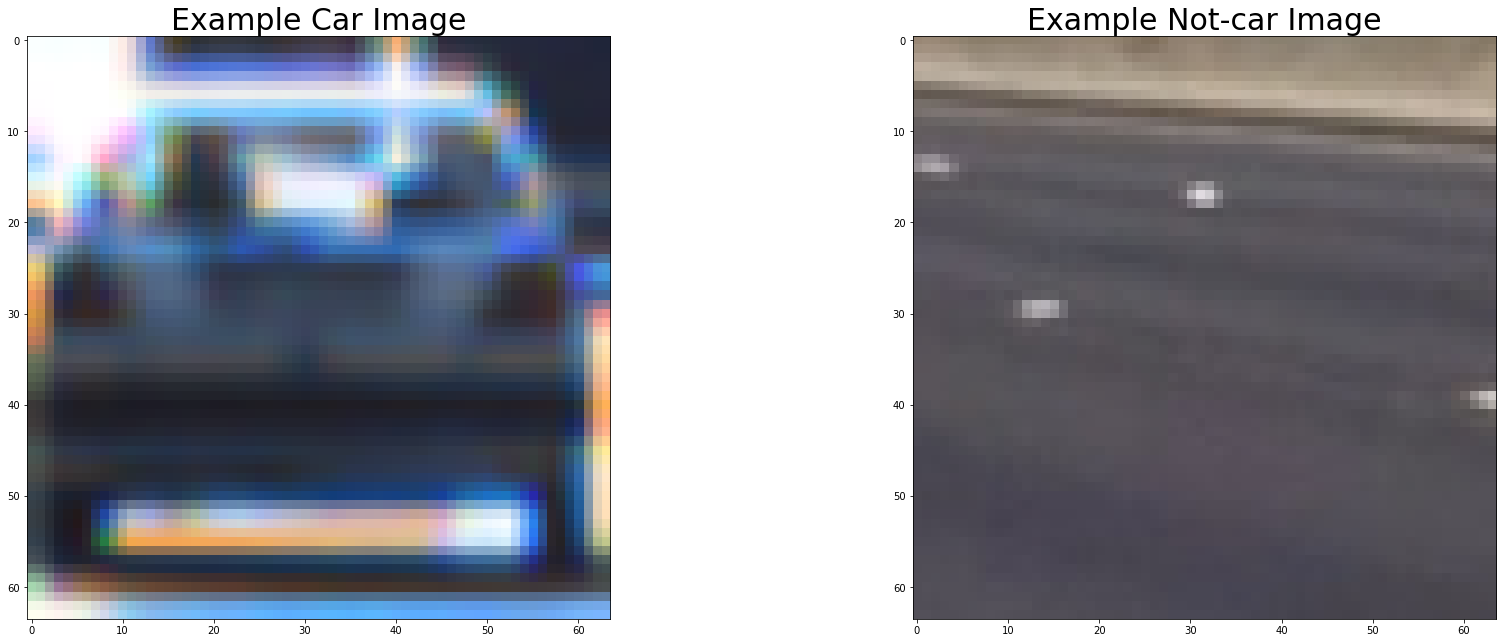

In [1]:
# read in the data
import matplotlib
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

# make list of all non-car images
images_notcars = glob.glob('./non-vehicles/Extras/*.png')
images_notcars.extend(glob.glob('./non-vehicles/GTI/*.png'))

# make list of all car images
images_cars = glob.glob('./vehicles/GTI_Far/*.png')
images_cars.extend(glob.glob('./vehicles/GTI_Left/*.png'))
images_cars.extend(glob.glob('./vehicles/GTI_MiddleClose/*.png'))
images_cars.extend(glob.glob('./vehicles/GTI_Right/*.png'))
images_cars.extend(glob.glob('./vehicles/KITTI_extracted/*.png'))
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(images_cars, images_notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(images_cars))
notcar_ind = np.random.randint(0, len(images_notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(images_cars[car_ind])
notcar_image = mpimg.imread(images_notcars[notcar_ind])

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Example Car Image', fontsize=30)
ax2.imshow(notcar_image)
ax2.set_title('Example Not-car Image', fontsize=30)
plt.savefig('./output_images/car_not_car.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# if already run, this cell doesn't have to be rerun
# prepare udacity labeled dataset 
# (https://github.com/udacity/self-driving-car/tree/master/annotations)

import pandas as pd
import pickle
from scipy.misc import imresize
from tqdm import tqdm
import random

# read and prepare labels.csv
labels = pd.read_csv('./object-detection-crowdai/labels.csv')
# just using car data (however, truck data is necessary for better/safer driving experinece, 
# same is true for pedestrians)
labels = labels[labels.Label == 'Car']
labels.drop('Preview URL', axis=1, inplace=True)
labels['Frame'] = ['./object-detection-crowdai/'+x for x in labels.Frame]
labels.reset_index(inplace = True, drop=True)
labels_array = np.array(labels)

# since there will only be car label images, we will need to create an equal amount of non-car images
# this function defines a random region
def rand_regio(ymax=1200,xmax=1920):
    starty = random.randrange(1,ymax)
    endy = starty + random.randrange(1,ymax-starty)
    startx = random.randrange(1,xmax)
    endx =startx + random.randrange(1,xmax-startx)
    
    return starty, endy, startx, endx

# since we cannot use any random regions that include a car, this function tests if any of the current 
# car locations (4 corners of bbox) are within the random region
# returns True if in region (this is bad for us)
# returns False if not in region (yay, good for us!)
def test_in_car_regio(dataf, starty, endy, startx, endx, Frame):
    # first we need to find all the cars within the image
    labels_selct = labels[labels.Frame==Frame]
    select_array = np.array(labels_selct)
    
    # now we'll take all corners
    corners = []
    
    for i in select_array:
        corners.append((i[0],i[1]))
        corners.append((i[2],i[3]))
        corners.append((i[1],i[2]))
        corners.append((i[3],i[0]))
    
    # test if a car bbox corner is within or random region
    result = []
    
    for corner in corners:
        if startx <= corner[0] <= endx and starty <= corner[1] <= endy:
            result.append(True)
        else:
            result.append(False)
            
    if True in result:
        return True
    else:
        return False

udacity_cars = []
udacity_notcars = []
# crop each car, resize and append to list
for row in tqdm(labels_array):
    # try except added because there were some images with classifications that don't work
    try:
        # read in image and crop to only show car
        img = cv2.imread(row[4])
        crop_img = img[row[1]:row[3],row[0]:row[2]]
        # resize to 64 x 64 x 3 and append to cars list
        final_img = imresize(crop_img,(64,64,3))
        udacity_cars.append(final_img)
        
        # define a random region and check if this region contains any of our cars (more specifically any bbox corners)
        starty, endy, startx, endx=rand_regio()
        test = test_in_car_regio(labels, starty, endy, startx, endx, row[4])
        
        # if our random region does contain some corners, define a new region and try again
        while test == True:
            starty, endy, startx, endx=rand_regio()
            test = test_in_car_regio(labels, starty, endy, startx, endx, row[4])
        
        # after we've found a good not car region, crop original image, resize to 64 x 64 x 3 and append to notcar list
        crop_img_not_car = img[starty:endy,startx:endx]
        final_img_not_car = imresize(crop_img_not_car,(64,64,3))
        udacity_notcars.append(final_img_not_car)
    except:
        pass

# save our new images as pickle (no need to write them back as actual images)
pickle.dump( udacity_cars, open( "udacity_cars.p", "wb" ) )
pickle.dump( udacity_notcars, open( "udacity_notcars.p", "wb" ) )

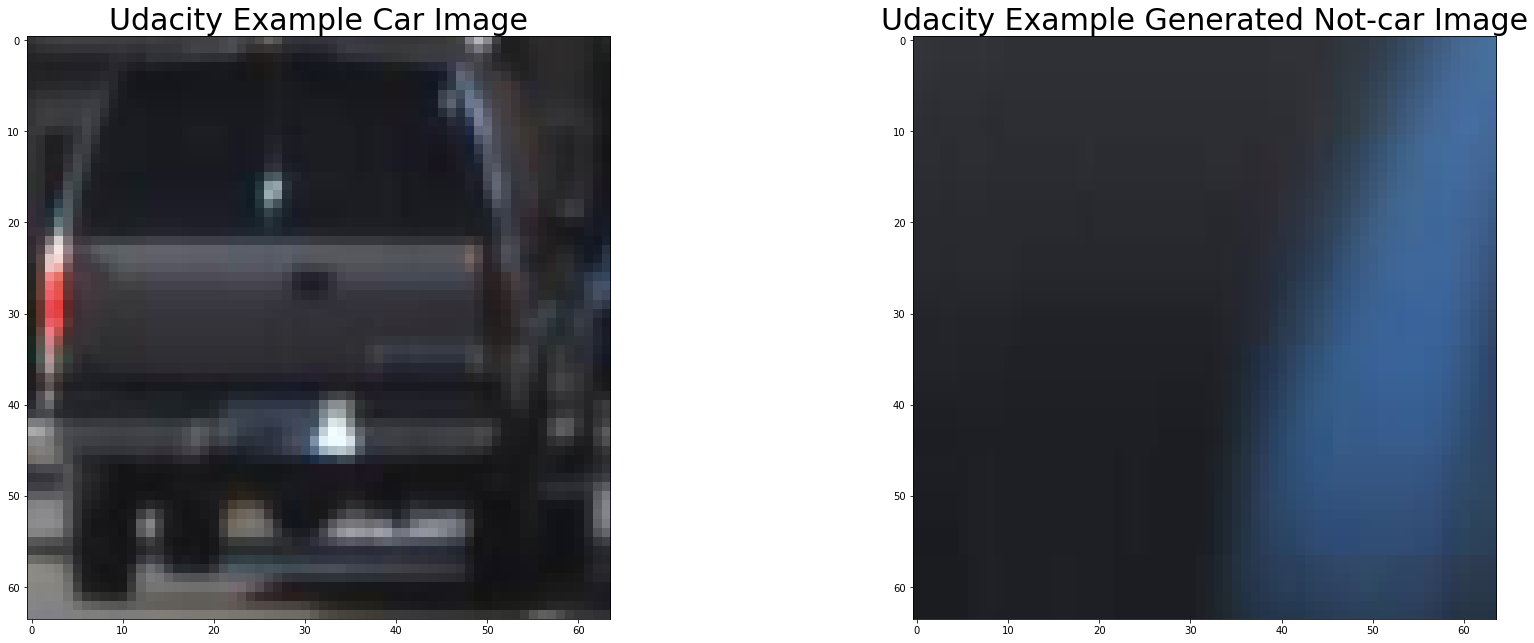

In [2]:
# import from pickle (so we don't have to rerun the cell above)
# and show random car and notcar picture from the udacity dataset

import pickle

udacity_cars = pickle.load(open('udacity_cars.p', 'rb'))
udacity_notcars = pickle.load(open('udacity_notcars.p', 'rb'))

car_ind = np.random.randint(0, len(udacity_cars))
notcar_ind = np.random.randint(0, len(udacity_notcars))
    
# Read in car / not-car images
car_image = udacity_cars[car_ind]
notcar_image = udacity_notcars[notcar_ind]

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Udacity Example Car Image', fontsize=30)
ax2.imshow(cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Udacity Example Generated Not-car Image', fontsize=30)
plt.savefig('./output_images/udacity_car_not_car.png',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# This code can be used to extend the current dataset with images from teh udacity labeled dataset.
# I worked with this at first but achieved better resuls without adding additional data
# This may be because the labeled dataset has a lot of city car images, parked, etc.
# I left this cell in the notebook for later use if necessary, and will only append 1 image from teh udacity dataset

# first we need to read in all of our data from the images_cars and images_notcars lists
cars = []
notcars = []

for image in images_cars:
    img = cv2.imread(image)
    cars.append(img)
    
for image in images_notcars:
    img = cv2.imread(image)
    notcars.append(img)
    
# print intermediate results of our list
# change data look function to not read in car image again
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars before adding udacity data')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Uncomment these lines to extend with all images
#cars.extend(udacity_cars)
#notcars.extend(udacity_notcars)

# define how many to add from udacity dataset
n_to_add = 1

# add them but shuffle before
np.random.shuffle(cars)
np.random.shuffle(notcars)
for i in range(n_to_add):
    car_ind = np.random.randint(0, len(udacity_cars))
    notcar_ind = np.random.randint(0, len(udacity_notcars))
    car_image = udacity_cars[car_ind]
    notcar_image = udacity_notcars[notcar_ind]
    cars.append(car_image)
    notcars.append(notcar_image)

# print result of our list
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars after adding udacity data')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# shuffle data before saving
np.random.shuffle(cars)
np.random.shuffle(notcars)

# save final training data to pickle for later use
pickle.dump( cars, open( "cars.p", "wb" ) )
pickle.dump( notcars, open( "notcars.p", "wb" ) )

Your function returned a count of 8792  cars and 8968  non-cars before adding udacity data
of size:  (64, 64, 3)  and data type: uint8
Your function returned a count of 8793  cars and 8969  non-cars after adding udacity data
of size:  (64, 64, 3)  and data type: uint8


In [4]:
# delete some variables because now we can just use our pickles (free up some RAM)
del cars
del notcars
del udacity_cars
del udacity_notcars
del images_cars
del images_notcars

## Step 1: Feature extraction and classifier training

In [5]:
# let's first read in or data and take a look at it

import matplotlib
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle

cars = pickle.load(open('cars.p', 'rb'))
notcars = pickle.load(open('notcars.p', 'rb'))

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8793  cars and 8969  non-cars
of size:  (64, 64, 3)  and data type: uint8


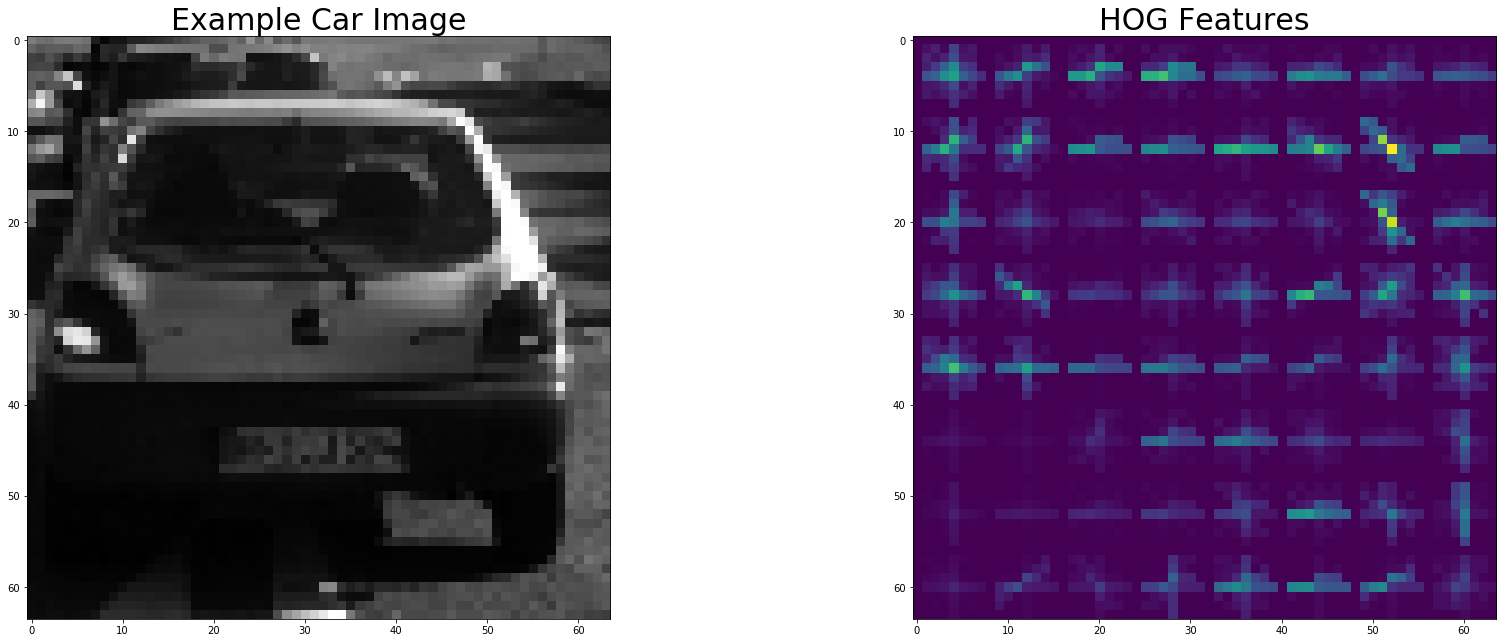

In [6]:
# Define a function to return HOG features and visualization
from scipy.misc import imresize
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# visualize output with test image
# example will take BGR image and visualize HOG features of grayscale
# final pipeline will take all channels after image is converted to 'LUV' colorspace
img = cv2.cvtColor(cars[0], cv2.COLOR_BGR2GRAY)

orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block

features, hog_image = get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Example Car Image', fontsize=30)
ax2.imshow(hog_image)
ax2.set_title('HOG Features', fontsize=30)
plt.savefig('./output_images/hog_features',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

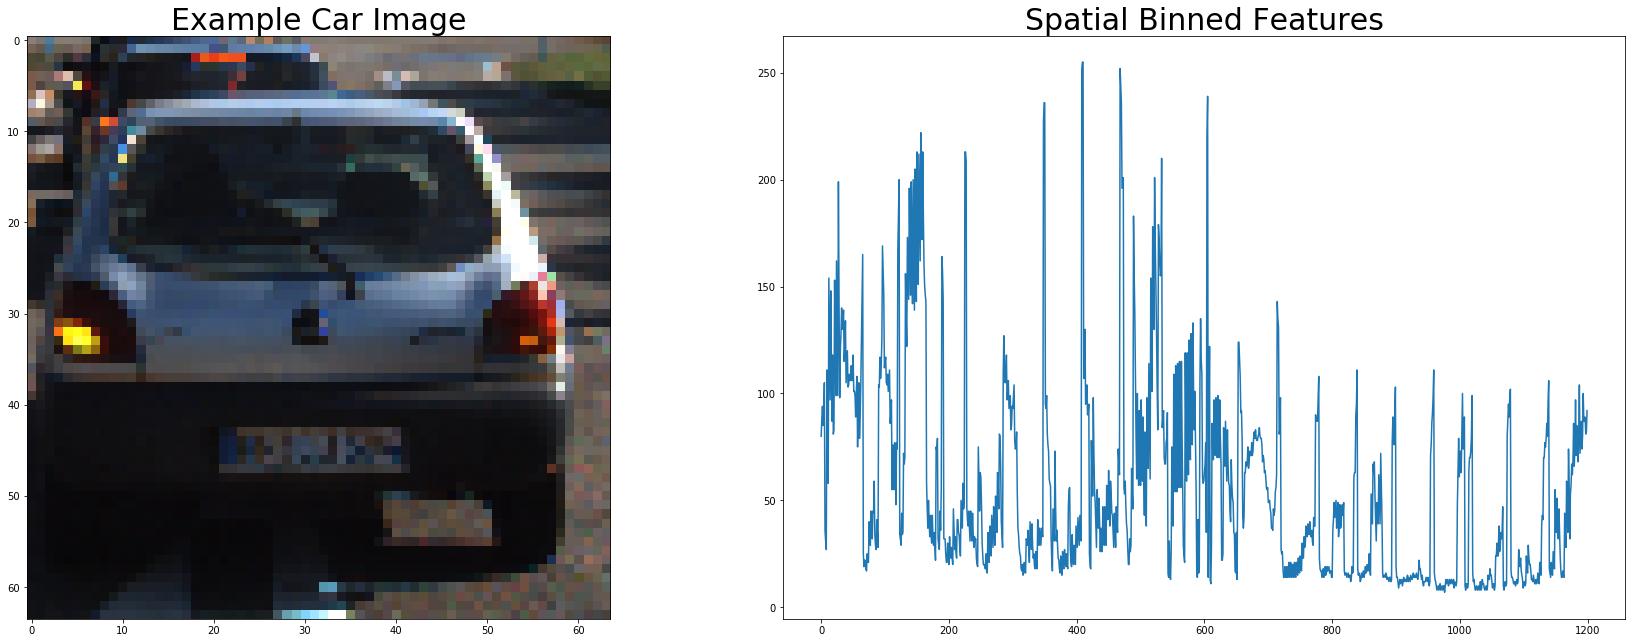

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# visualize output with test image
# example will take BGR image and visualize binned spatial features
# pipeline will transform to 'LUV' colorspace before binning
img = cars[0]
spatial_size = (20, 20) # Spatial binning dimensions

features = bin_spatial(img, size=spatial_size)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Example Car Image', fontsize=30)
ax2.plot(features)
ax2.set_title('Spatial Binned Features', fontsize=30)
plt.savefig('./output_images/spatial_features',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

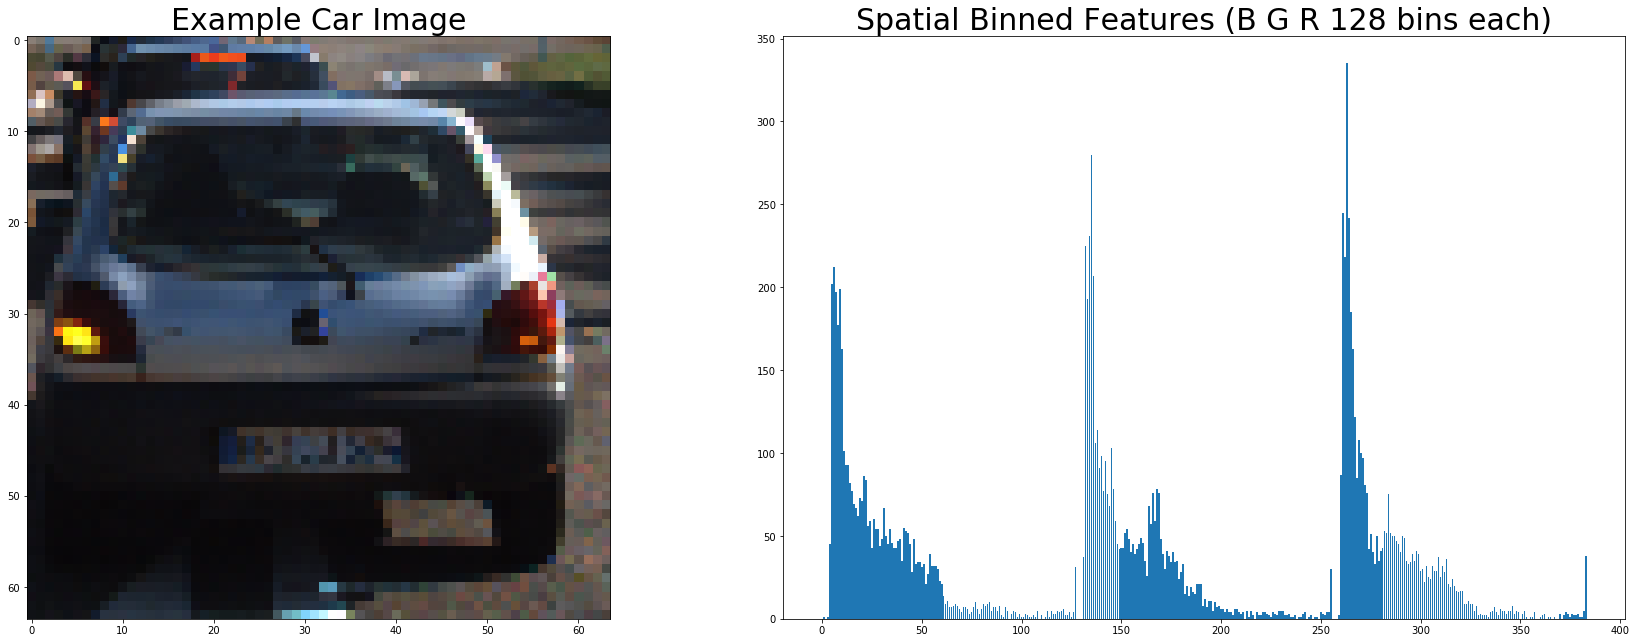

In [8]:
# Define a function to compute color histogram features 
# caution! range might differ if images are read in differently
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# visualize output with test image
# example will take BGR image and visualize color hist features
# pipeline will transform into 'LUV' color space before color hist binning
img = cars[0]
hist_bins = 128

hist_features = color_hist(img, nbins=hist_bins, bins_range=(0, 256))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Example Car Image', fontsize=30)
ax2.bar([x for x in range(len(hist_features))],hist_features)
ax2.set_title('Spatial Binned Features (B G R 128 bins each)', fontsize=30)
plt.savefig('./output_images/color_hist_features',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
# Define a function to extract features from a list of images
from tqdm import tqdm

def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        file_features = []
        # apply color conversion if other than 'BGR'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [10]:
# extract the features from our 'car' and 'notcar' image lists
from sklearn.preprocessing import StandardScaler

color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (20, 20) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print('Extracting car features...')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Extracting notcar features...')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# save our results
pickle.dump( scaled_X, open( "scaled_X.p", "wb" ) )
pickle.dump( y, open( "y.p", "wb" ) )
pickle.dump(X_scaler, open( "X_scaler.p", "wb"))

Extracting car features...


100%|██████████████████████████████████████████████████████████████████████████████████| 8793/8793 [00:38<00:00, 228.22it/s]


Extracting notcar features...


100%|██████████████████████████████████████████████████████████████████████████████████| 8969/8969 [00:39<00:00, 227.01it/s]


In [ ]:
# delete variables we don't need anymore
del cars
del notcars

In [11]:
# fit model
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import time
import pickle

# split data in test and train set
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1)

# delete variables we don't need anymore
del scaled_X
del y

# I experimented with different options using 'GridSearchCV' but ended up using a LinearSVC

print('Training...')

# uncomment the next lines to use Gridsearch
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 0.1, 1e-4]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters, verbose=100, n_jobs=4) # use n_jobs for parallelization

clf = LinearSVC(C=1e-4)
clf.fit(X_train, y_train)

# results of grid search
#results_dict = clf.cv_results_
#print('Results:')
#print(results_dict)

#print('Best Parameters:')
#print(clf.best_params_)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# better save than sorry
pickle.dump( clf, open( "clf.p", "wb" ) )

Training...
Test Accuracy of SVC =  0.9949
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
0.01906 Seconds to predict 10 labels with SVC


In [12]:
# uncomment these lines to show a dataframe of the grid search results
#import pandas as pd
#df_search_results = pd.DataFrame.from_dict(results_dict)
#df_search_results

## Step 2: Implement sliding window search

In [13]:
# define function to slide windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

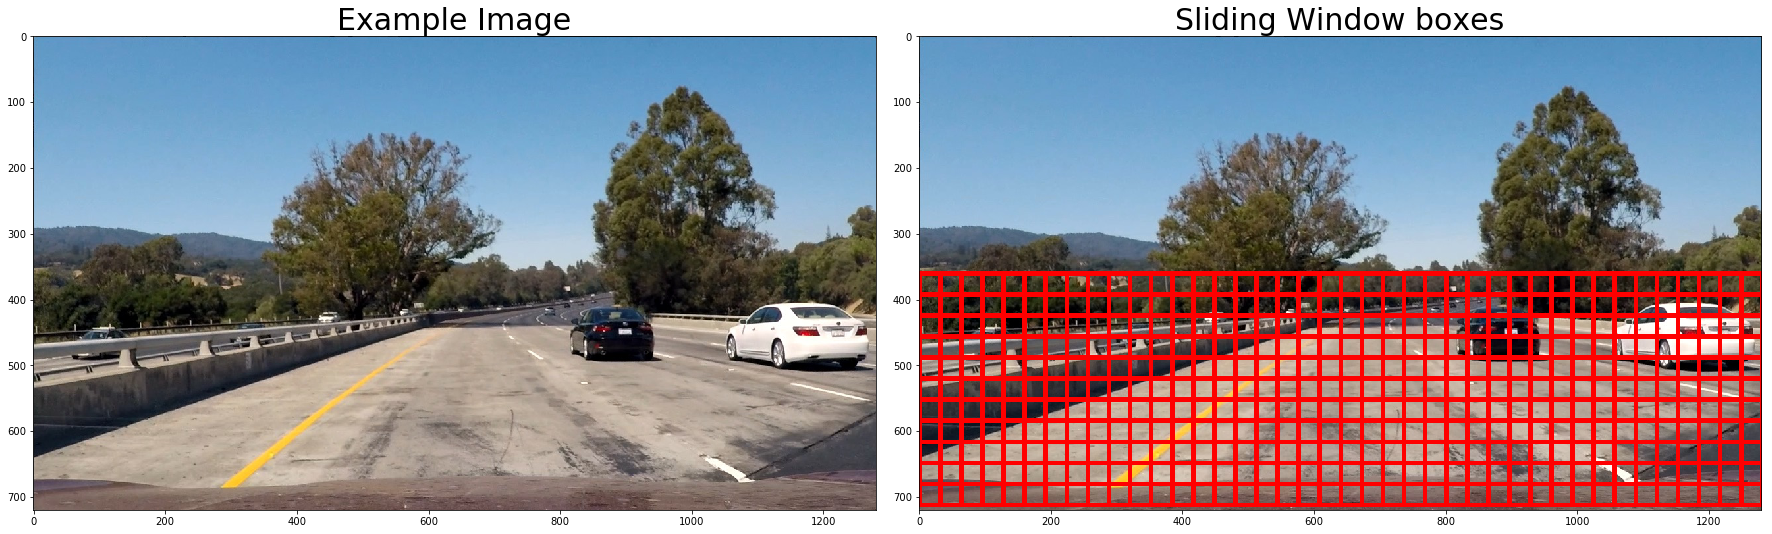

In [14]:
# read in sample image to show bounding boxes on image
img = cv2.imread('./test_images/test1.jpg')
y_start_stop = [360, None] # Min and max in y to search in slide_window()

windows = slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5))
boxes = draw_boxes(img, windows, color=(0, 0, 255), thick=6)

# visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Example Image', fontsize=30)
ax2.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB))
ax2.set_title('Sliding Window boxes', fontsize=30)
plt.savefig('./output_images/boxes',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

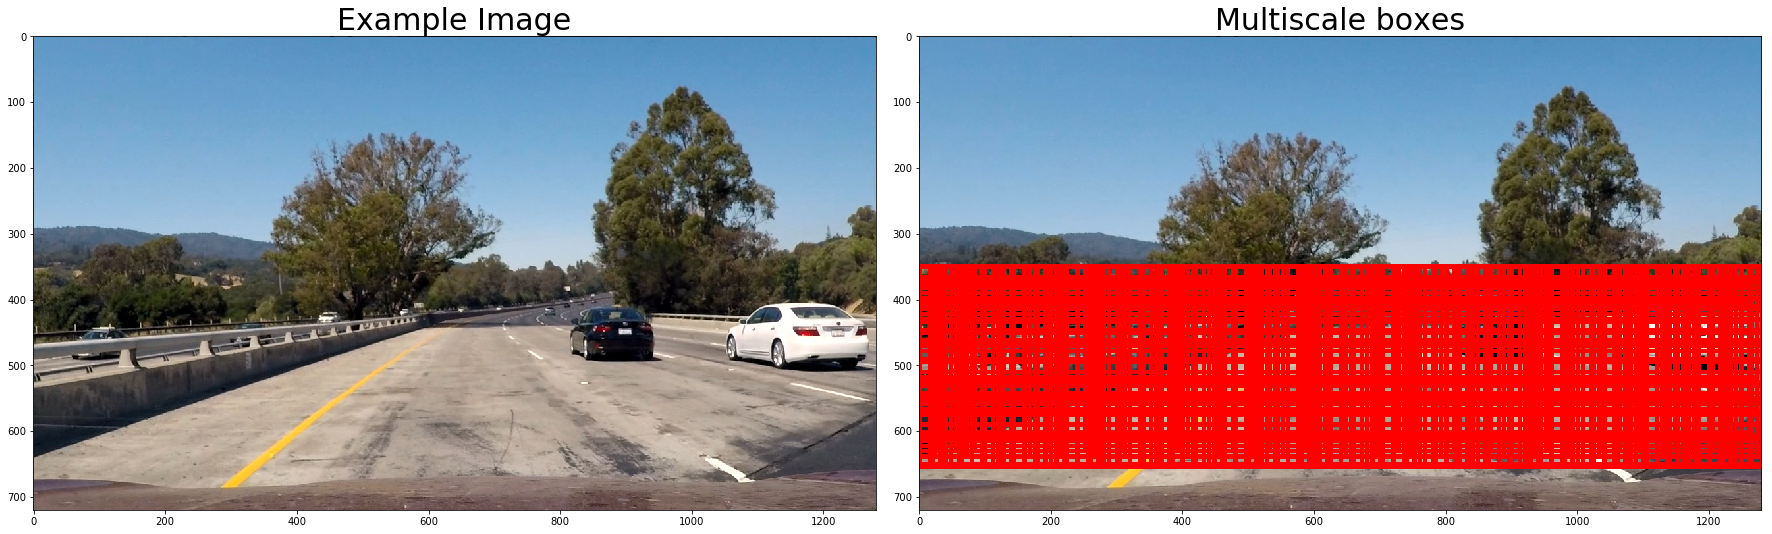

In [15]:
# for better / more lightweight processing the regions can be adapted
# adjust the search windows, far back cars will be smaller, close up cars will be bigger

# read in sample image to show bounding boxes on image
img = cv2.imread('./test_images/test1.jpg')

windows = []

y_start_stop = [350, 656] # Min and max in y to search in slide_window()

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(80, 80), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(112, 112), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(128, 128), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(160, 160), xy_overlap=(0.75, 0.75)))

boxes = draw_boxes(img, windows, color=(0, 0, 255), thick=6)

# visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Example Image', fontsize=30)
ax2.imshow(cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB))
ax2.set_title('Multiscale boxes', fontsize=30)
plt.savefig('./output_images/multiscale_boxes',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [16]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'BGR'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:
# Define a function to will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

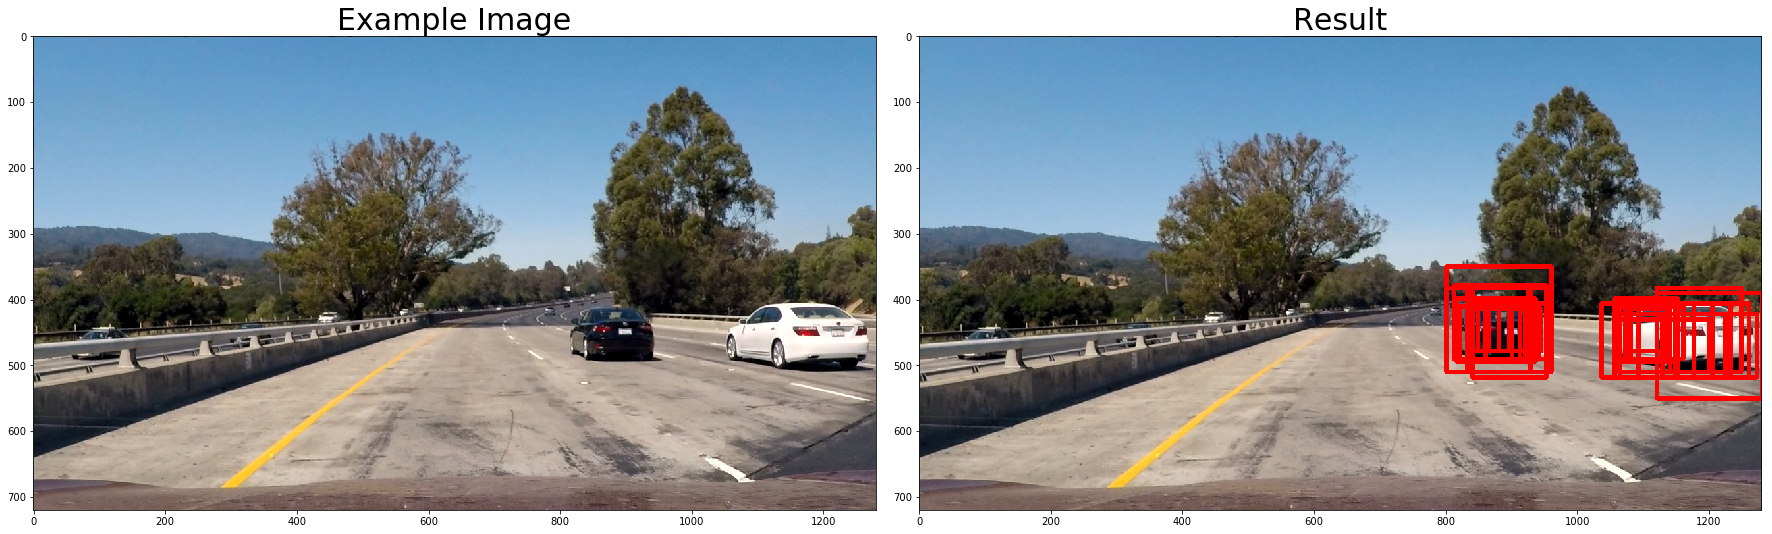

In [18]:
# test pipeline
clf = pickle.load(open('clf.p','rb'))
X_scaler = pickle.load(open('X_scaler.p','rb'))

color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (20, 20) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

image = cv2.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

windows = []

y_start_stop = [350, 656] # Min and max in y to search in slide_window()

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(80, 80), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(112, 112), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(128, 128), xy_overlap=(0.75, 0.75)))

windows.extend(slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(160, 160), xy_overlap=(0.75, 0.75)))

hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Example Image', fontsize=30)
ax2.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Result', fontsize=30)
plt.savefig('./output_images/pipeline_result',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step3: create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles

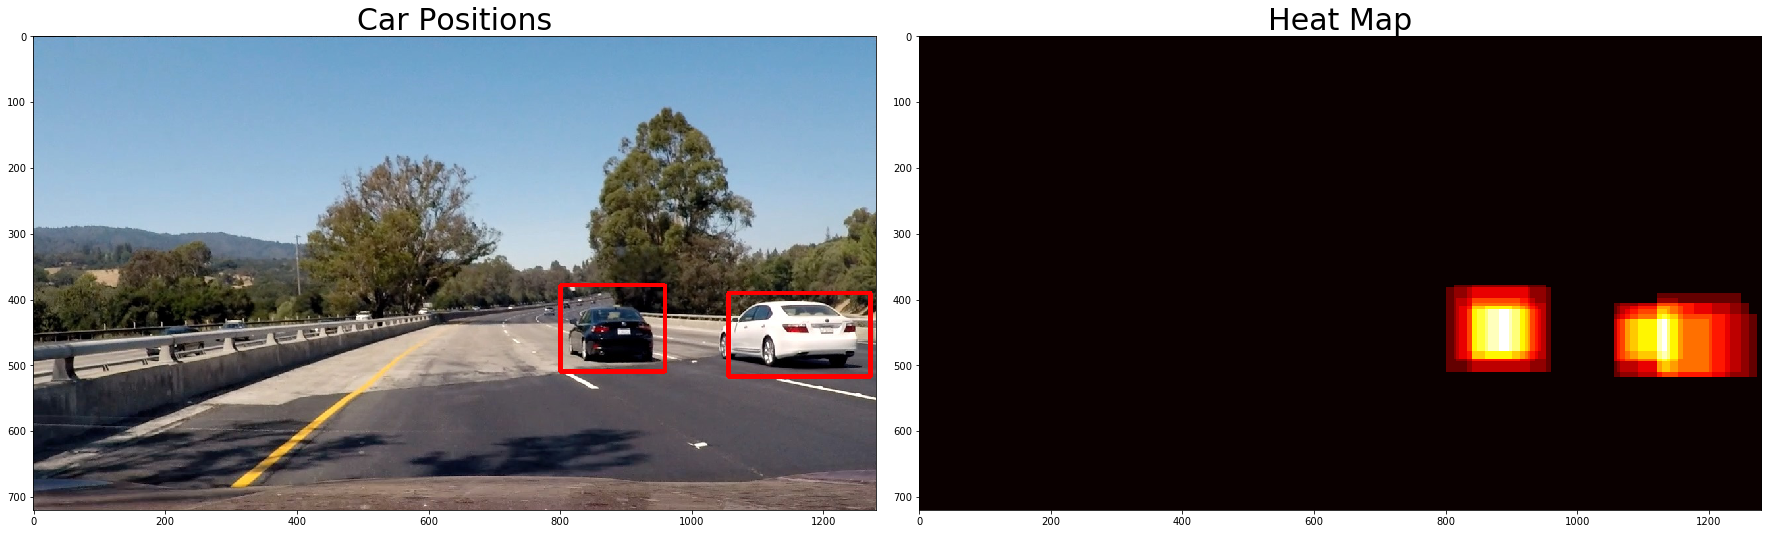

In [19]:
from scipy.ndimage.measurements import label

# use boxes from image above
box_list = hot_windows

# Read in image similar to one shown above 
image = cv2.imread('./test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

# visualize
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Car Positions', fontsize=30)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=30)
plt.savefig('./output_images/heat_map_result',bbox_inches='tight')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 4: Implement clean pipeline

In [3]:
# make a nice and clean pipeline, so that the notebook can be run from this point

import matplotlib
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
from scipy.misc import imresize
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def single_img_features(img, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

class Find_Cars():
    def __init__(self):
        
        # use heat from last n frames to smooth bounding boxes
        self.history = deque(maxlen=12) # where n_frames is number of history frames
 
        self.clf = pickle.load(open('clf.p','rb'))
        self.X_scaler = pickle.load(open('X_scaler.p','rb'))
        
        self.windows = []
        
    def pipeline(self, img):

        # DON'T change values unless also changing them when features were extracted for training the classifier
        color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
        orient = 12  # HOG orientations
        pix_per_cell = 8 # HOG pixels per cell
        cell_per_block = 1 # HOG cells per block
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        spatial_size = (20, 20) # Spatial binning dimensions
        hist_bins = 128    # Number of histogram bins
        spatial_feat = True # Spatial features on or off
        hist_feat = True # Histogram features on or off
        hog_feat = True # HOG features on or off
        
        if len(self.windows)==0:
            y_start_stop = [350, 656] # Min and max in y to search in slide_window()
        
            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.75, 0.75)))

            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(80, 80), xy_overlap=(0.75, 0.75)))

            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(112, 112), xy_overlap=(0.75, 0.75)))

            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(128, 128), xy_overlap=(0.75, 0.75)))

            self.windows.extend(slide_window(img, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(160, 160), xy_overlap=(0.75, 0.75)))

        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        hot_windows = search_windows(img, self.windows, self.clf, self.X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)
    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        self.history.append(heat)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(np.sum(self.history, axis=0), 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        return draw_img

In [4]:
# test pipeline on test_video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

carfinder = Find_Cars()
def process_image(img, carfinder=carfinder):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(carfinder.pipeline(img), cv2.COLOR_BGR2RGB)

video_out = 'output_test_video.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|████████████████████████████████████████████████████████████████████████████████████▊  | 38/39 [08:00<00:11, 11.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

Wall time: 8min 1s


Ok that works. Slow, but it works. Below I'm using hog sub sampling to speed things up for the actual project video. The process is the same, but hog features are only extracted once and then subsampled. Also, 'process_image' changed slightly because there is no need to transfer from BGR to RGB colorspace.

In [5]:
# make a nice and clean pipeline, so that the notebook can be run from this point

import matplotlib
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
from scipy.misc import imresize
from skimage.feature import hog
from scipy.ndimage.measurements import label
from collections import deque

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_window = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_window.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return on_window

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

class Find_Cars_HSUB():
    def __init__(self):
        
        # use heat from last n frames to smooth bounding boxes
        self.history = deque(maxlen=12) # where n_frames is number of history frames
        
        self.clf = pickle.load(open('clf.p','rb'))
        self.X_scaler = pickle.load(open('X_scaler.p','rb'))
        
    def pipeline(self, img):

        # DON'T change values unless also changing them when features were extracted for training the classifier
        orient = 12  # HOG orientations
        pix_per_cell = 8 # HOG pixels per cell
        cell_per_block = 1 # HOG cells per block
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        spatial_size = (20, 20) # Spatial binning dimensions
        hist_bins = 128    # Number of histogram bins
        spatial_feat = True # Spatial features on or off
        hist_feat = True # Histogram features on or off
        hog_feat = True # HOG features on or off
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        
        ystart = 350
        ystop =656
        
        scale = 1.0

        hot_windows = find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        scale = 1.25

        hot_windows.extend(find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

        scale = 1.5

        hot_windows.extend(find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
        scale = 1.75

        hot_windows.extend(find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

        scale = 2.0

        hot_windows.extend(find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
        scale = 2.5

        hot_windows.extend(find_cars(img, ystart, ystop, scale, self.clf, 
                                self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
        
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)
    
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,1)
        self.history.append(heat)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(np.sum(self.history, axis=0), 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        return draw_img

In [6]:
# use the new pipeline to process the project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

carfinder = Find_Cars_HSUB()
def process_image(img, carfinder=carfinder):
    return carfinder.pipeline(img)

video_out = 'output_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [55:53<00:02,  2.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 55min 54s
